In [2]:
pip install numpy pandas tensorflow scikit-learn matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Load dataset
df = pd.read_json("crane_sensor_data.json")

# Select sensor columns
sensor_columns = ["temperature", "load", "sound", "vibration", "power", "ultrasonic", "fuel_consumption"]
X = df[sensor_columns]

# Normalize data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Define Autoencoder
input_dim = X_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation="relu")(input_layer)
encoded = Dense(8, activation="relu")(encoded)
encoded = Dense(4, activation="relu")(encoded)

decoded = Dense(8, activation="relu")(encoded)
decoded = Dense(16, activation="relu")(decoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

# Train Autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=32, shuffle=True, validation_split=0.1)

# Reconstruct Data
X_pred = autoencoder.predict(X_scaled)

# Compute Reconstruction Error
mse = np.mean(np.power(X_scaled - X_pred, 2), axis=1)

# Set Anomaly Threshold
threshold = np.percentile(mse, 90)  # Top 10% as anomalies
df["anomaly"] = mse > threshold

Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0792 - val_loss: 0.0665
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0635 - val_loss: 0.0597
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0586 - val_loss: 0.0476
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0483 - val_loss: 0.0467
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0482 - val_loss: 0.0466
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0476 - val_loss: 0.0464
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0475 - val_loss: 0.0463
Epoch 8/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0470 - val_loss: 0.0461
Epoch 9/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0471 - val_loss: 0.0464
Epoch 10/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0469 - val_loss: 0.0458
Epoch 11/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0465 - val_loss: 0.0458
Epoch 12/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

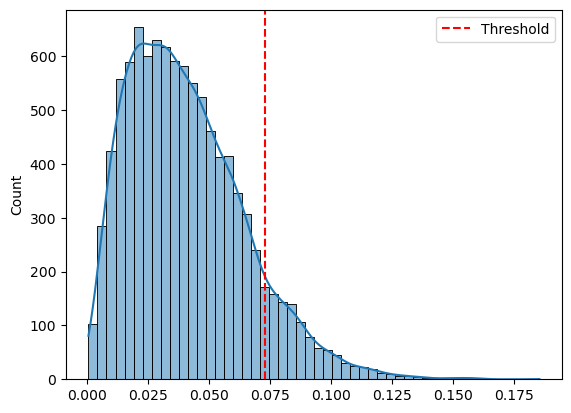

anomaly
False    9000
True     1000
Name: count, dtype: int64


In [7]:
# Plot Histogram
sns.histplot(mse, bins=50, kde=True)
plt.axvline(threshold, color="r", linestyle="dashed", label="Threshold")
plt.legend()
plt.show()

# Count anomalies
print(df["anomaly"].value_counts())